<a href="https://colab.research.google.com/github/dmburns1729/Class-Files/blob/main/ROC_AUC_Code_along_Notebook_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Thresholds and ROC AUC

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, make_column_selector,
                             make_column_transformer)
from sklearn.metrics import (roc_auc_score, ConfusionMatrixDisplay,
                             PrecisionRecallDisplay, RocCurveDisplay,
                             f1_score, accuracy_score, classification_report)

In [ ]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTRfoQAojPwNsw33zUSpBg32DuK2z0WvLPptGOncIXa38tN3RWk9puvelcmsIIhFb_XF12RD7PdqCwf/pub?output=csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
ml_df = df.copy()

In [ ]:
ml_df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [ ]:
ml_df.duplicated().sum()

0

In [ ]:
X = ml_df.drop('HeartDisease', axis=1)
y = ml_df['HeartDisease']

labels=['No Heart Disease', 'Heart Disease']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24)


## Preprocessing

In [ ]:
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')

preprocessor = make_column_transformer( (OneHotEncoder(), cat_sel),
                                       (StandardScaler(), num_sel),
                                               remainder='drop')
preprocessor

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f80333fefd0>),
                                ('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f80333fef90>)])

## Modeling

- Fit a LogisticRegression model

In [ ]:
# fit model
lgr_pipe = make_pipeline(preprocessor, LogisticRegression())
lgr_pipe.fit(X_train, y_train)

# get predictions
train_preds = lgr_pipe.predict(X_train)
test_preds = lgr_pipe.predict(X_test)

train_preds[:5]

array([1, 1, 1, 1, 0])

### Evaluating Our Model

In [ ]:
# print the classiffication report from the test data
print(classification_report(y_test, test_preds, target_names=labels ))

                  precision    recall  f1-score   support

No Heart Disease       0.87      0.81      0.84       105
   Heart Disease       0.85      0.90      0.87       125

        accuracy                           0.86       230
       macro avg       0.86      0.85      0.85       230
    weighted avg       0.86      0.86      0.86       230



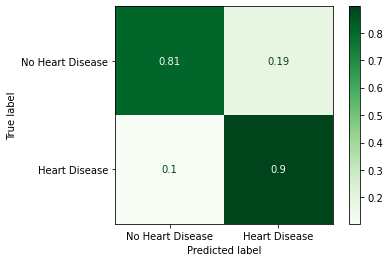

In [ ]:
# create a confusion matrix with the test data
ConfusionMatrixDisplay.from_predictions(y_test, test_preds,
               normalize='true', display_labels=labels, cmap='Greens');

## Changing Decision Thresholds

In [ ]:
# Get the predicted probabilities instead of predicted classes
train_probs = lgr_pipe.predict_proba(X_train)
test_probs = lgr_pipe.predict_proba(X_test)

train_probs[:5]

array([[0.08428568, 0.91571432],
       [0.27435256, 0.72564744],
       [0.23942749, 0.76057251],
       [0.01292634, 0.98707366],
       [0.94595027, 0.05404973]])

- What if we used a probability threshold of 0.4 instead of the default (0.5)?

In [ ]:
thresh = 0.30

# use list comprehension to apply threshold to 2nd value in each prediction
train_thresh = [1 if x[1] > thresh else 0 for x in train_probs]
test_thresh = [1 if x[1] > thresh else 0 for x in test_probs]

print(f'Predictions with the default decision threshold of .5')
print(train_preds[:5], '\n')

print(f'Predictions with a decision threshold of {thresh}')
print(train_thresh[:5], '\n')

print('True Labels')
print(y_train[:5].values)

Predictions with the default decision threshold of .5
[1 1 1 1 0] 

Predictions with a decision threshold of 0.3
[1, 1, 1, 1, 0] 

True Labels
[1 1 0 1 0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Comparing Confusion Matrices for Both Thresholds

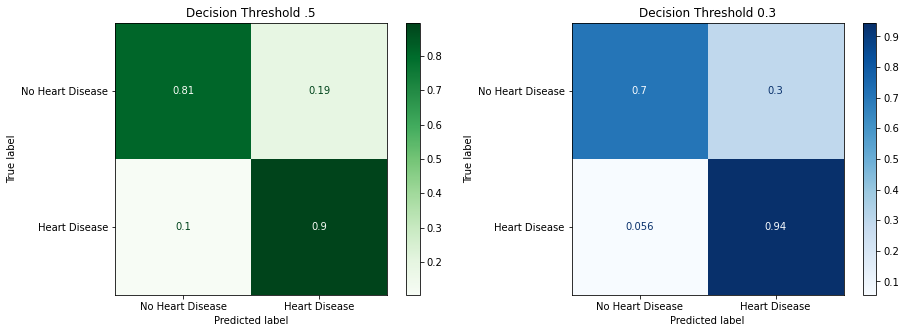

In [ ]:
# plot confusion matrix for both .5 and 'thresh' thresholds
fig, axes = plt.subplots(1,2, figsize=(15,5))

ConfusionMatrixDisplay.from_predictions(y_test, test_preds,
               normalize='true', display_labels=labels,  cmap='Greens',
               ax=axes[0])
axes[0].set_title('Decision Threshold .5')


ConfusionMatrixDisplay.from_predictions(y_test, test_thresh,
               normalize='true', display_labels=labels,  cmap='Blues',
               ax=axes[1])

axes[1].set_title(f'Decision Threshold {thresh}');

## Loop Over Decision Thresholds

- Let's check our model's accuracy for 20 different probabiltiy thresholds and compare.

In [ ]:
# Create an array of 20 thesholds to use
thresholds = np.array(range(0,105,5)) / 100
thresholds[:5]

array([0.  , 0.05, 0.1 , 0.15, 0.2 ])

Text(0, 0.5, 'Accuracy Score')

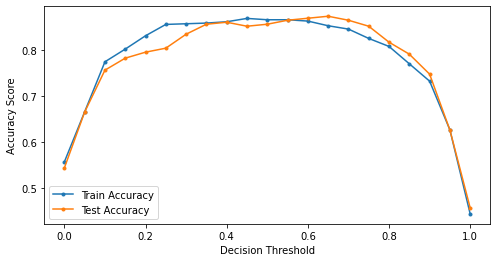

In [ ]:

score_df = pd.DataFrame(index=thresholds, columns=['Train Accuracy','Test Accuracy'])

## for each threshold:
for thresh in thresholds:

  ## Get the predicted classes for training and test data
  train_thresh = [1 if x[1] > thresh else 0 for x in train_probs]
  test_thresh = [1 if x[1] > thresh else 0 for x in test_probs]

  ## Save the Training and test accuracy scores to the score_df
  score_df.loc[thresh, 'Train Accuracy'] = accuracy_score(train_thresh, y_train)
  score_df.loc[thresh, 'Test Accuracy'] = accuracy_score(test_thresh, y_test)


## Plot the results
score_df.plot(marker='.',figsize=(8,4))
plt.xlabel('Decision Threshold')
plt.ylabel('Accuracy Score')

In [ ]:
df['HeartDisease'].value_counts(normalize=True)

1    0.553377
0    0.446623
Name: HeartDisease, dtype: float64

In [ ]:
score_df.sort_values(by='Test Accuracy', ascending=False)

,Train Accuracy,Test Accuracy
0.65,0.853198,0.873913
0.60,0.863372,0.869565
0.70,0.84593,0.865217
0.55,0.866279,0.865217
0.40,0.861919,0.86087
0.50,0.866279,0.856522
0.35,0.859012,0.856522
0.75,0.825581,0.852174
0.45,0.869186,0.852174
0.30,0.857558,0.834783


# ROC Curve

- sklearn has a RocCurveDisplay visualizer to calculate the True Positive Rate vs the False Positive Rate at various probability thresholds.
- It then plots the curve and annotates the Area Under the Curve(AUC)

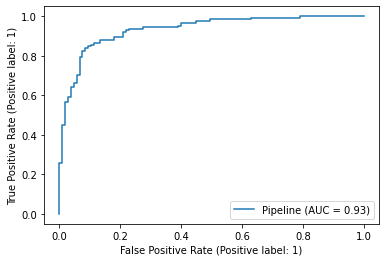

In [ ]:
RocCurveDisplay.from_estimator(lgr_pipe, X_test, y_test);

# 🕹 Creating an `evaluate_classification` function

- Let's combine the model evaluation steps for classification models into a new function called `evaluate_classification`.

- The function should have the following arguments:
  - model
  - X_test
  - y_test
  - + any other plot customization options.

- Inside the function, it will:
  - Print a header with a label indicating if we are evaluating Training Data or Test data.

  - Get the predictions for X_test from the model.
  - Get and print a classification_report
  - Create a figure with 2 subplots:
    - a Confusion Matrix
    - a ROC Curve Display
  

In [ ]:
## define the evaluate_classification function here

def evaluate_classiffication(lgr_pipe, X_test, y_test, label="Test Data"):
  test_preds = lgr_pipe.predict(X_test)


   ## Print classification report for the test data (and make it pretty!)
  print('---'*20)
  print(f"[i] CLASSIFICATION REPORT FOR: {label}")
  print('---'*20)
  # print the classiffication report from the test data
  print(classification_report(y_test, test_preds))

  fig, axes = plt.subplots(1,2, figsize=(15,5))

  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_test, test_preds,
               normalize='true', cmap='Greens',
               ax = axes[0]);

  RocCurveDisplay.from_estimator(lgr_pipe, X_test, y_test, ax=axes[1])
  plt.show()

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       105
           1       0.85      0.90      0.87       125

    accuracy                           0.86       230
   macro avg       0.86      0.85      0.85       230
weighted avg       0.86      0.86      0.86       230



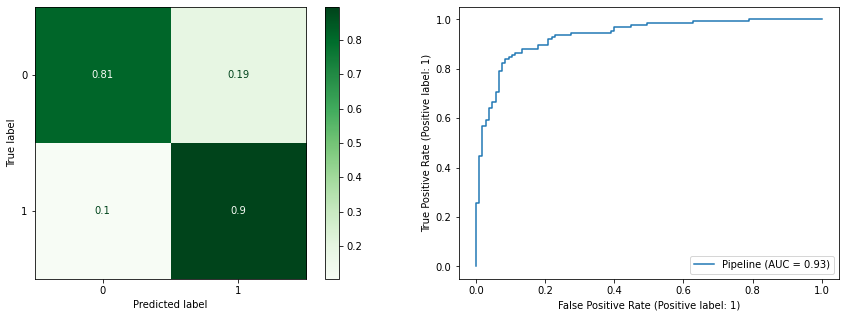

In [ ]:
evaluate_classiffication(lgr_pipe, X_test, y_test, label='Test Data')

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       305
           1       0.87      0.89      0.88       383

    accuracy                           0.87       688
   macro avg       0.87      0.86      0.86       688
weighted avg       0.87      0.87      0.87       688



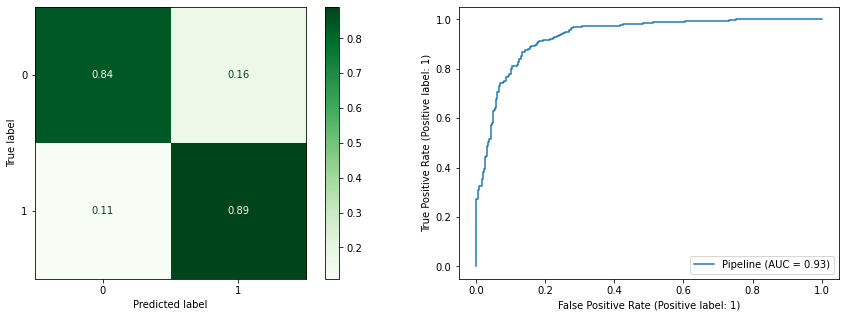

In [ ]:
evaluate_classiffication(lgr_pipe, X_train, y_train, label="Training Data")

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       305
           1       0.87      0.89      0.88       383

    accuracy                           0.87       688
   macro avg       0.87      0.86      0.86       688
weighted avg       0.87      0.87      0.87       688



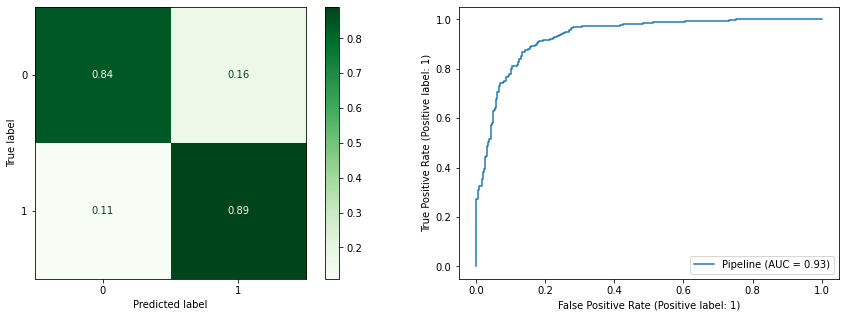

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       105
           1       0.85      0.90      0.87       125

    accuracy                           0.86       230
   macro avg       0.86      0.85      0.85       230
weighted avg       0.86      0.86      0.86       230



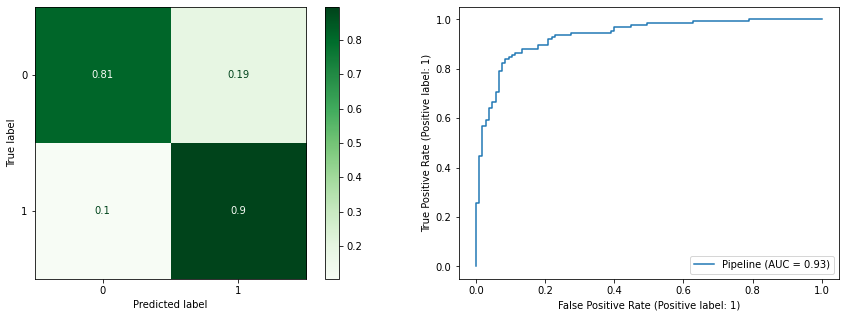

In [ ]:
evaluate_classiffication(lgr_pipe, X_train, y_train, label="Training Data")
evaluate_classiffication(lgr_pipe, X_test, y_test, label='Test Data')

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       105
           1       0.85      0.90      0.87       125

    accuracy                           0.86       230
   macro avg       0.86      0.85      0.85       230
weighted avg       0.86      0.86      0.86       230



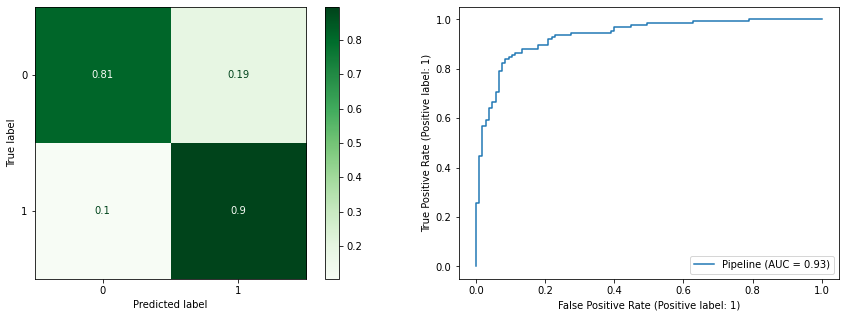

In [ ]:
## Evaluate our model using our function with the test data

evaluate_classiffication(lgr_pipe, X_test, y_test, label='Test Data')

In [ ]:
# Use the function twice to evaluate our model on training AND test data


## 🤔 Why is it worth taking the time to write a high quality function?

- What if we wanted to add 3 additional types of models to our project?
- Q: How many lines of code would we have to create to add an additional model?


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       105
           1       0.86      0.94      0.90       125

    accuracy                           0.88       230
   macro avg       0.89      0.88      0.88       230
weighted avg       0.89      0.88      0.88       230



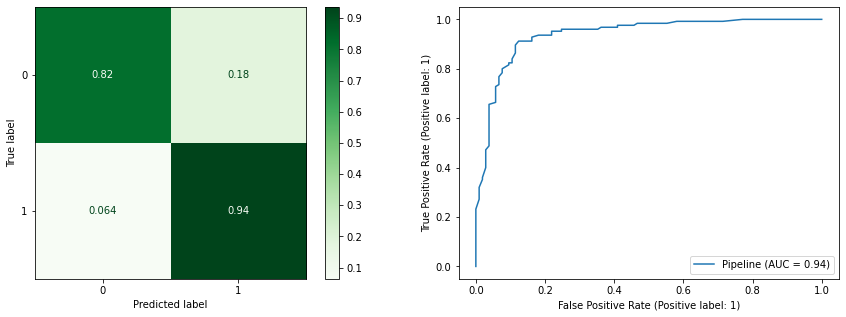

In [ ]:
# fit and evaluate a RandomForestClassifier
rf = RandomForestClassifier()
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe.fit(X_train, y_train)
evaluate_classiffication(rf_pipe, X_test, y_test)

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       105
           1       0.89      0.94      0.91       125

    accuracy                           0.90       230
   macro avg       0.90      0.90      0.90       230
weighted avg       0.90      0.90      0.90       230



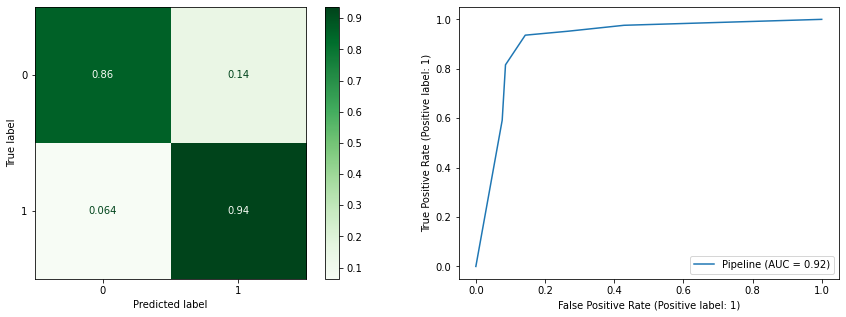

In [ ]:
# fit and evaluate a KNeighborsClassifier
# fit and evaluate a RandomForestClassifier
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(preprocessor,knn)
knn_pipe.fit(X_train, y_train)
evaluate_classiffication(knn_pipe, X_test, y_test)

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       105
           1       0.88      0.92      0.90       125

    accuracy                           0.89       230
   macro avg       0.89      0.89      0.89       230
weighted avg       0.89      0.89      0.89       230



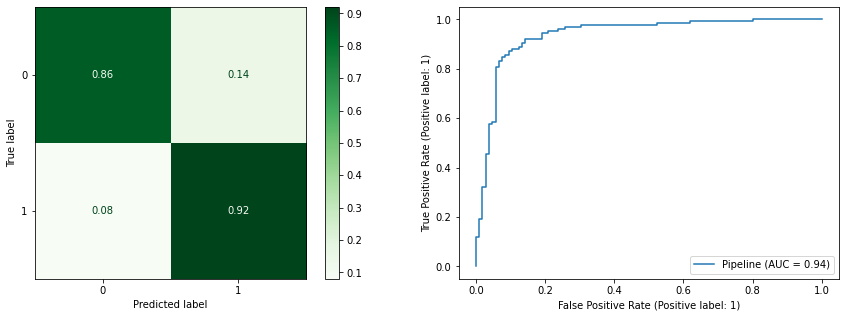

In [ ]:
# fit and evaluate an XGBoost Classifier

xgb = XGBClassifier()
xgb_pipe = make_pipeline(preprocessor,xgb)
xgb_pipe.fit(X_train, y_train)
evaluate_classiffication(xgb_pipe, X_test, y_test)

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       305
           1       0.93      0.95      0.94       383

    accuracy                           0.93       688
   macro avg       0.93      0.93      0.93       688
weighted avg       0.93      0.93      0.93       688



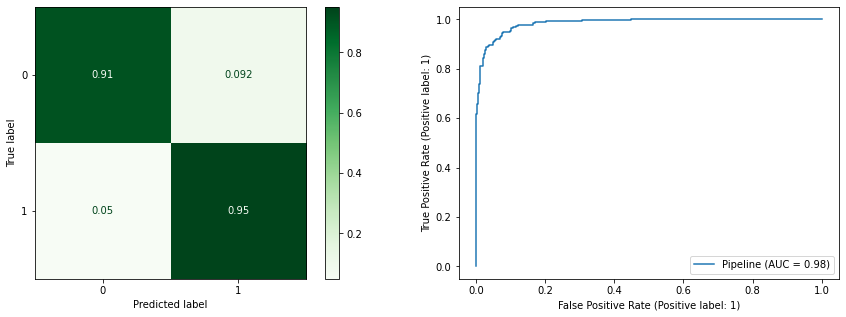

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       105
           1       0.88      0.92      0.90       125

    accuracy                           0.89       230
   macro avg       0.89      0.89      0.89       230
weighted avg       0.89      0.89      0.89       230



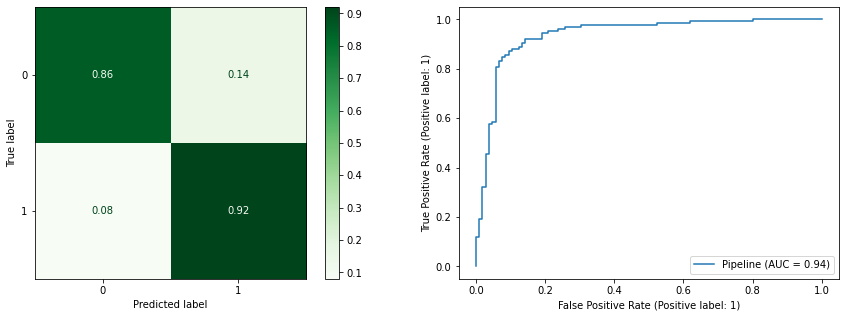

In [ ]:
evaluate_classiffication(xgb_pipe, X_train, y_train, label='Train Data')
evaluate_classiffication(xgb_pipe, X_test, y_test, label='Test Data')

- We only needed to add 3 lines of code to add a new model and its evaluation!

# Precision Recall Curve


- There's an additional visualizer that we can ues that will use various probability thresholds to evaluate the model's performance: the `PrecisionRecallDisplay`.

- The `PrecisionRecallDisplay` will also test many probability thresholds, but instead of plotting TPR vs FPR for the different thresholds, it will plot the Precision vs Recall for the different thresholds:


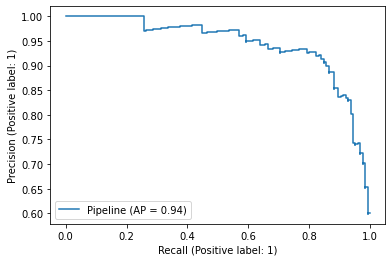

In [ ]:
PrecisionRecallDisplay.from_estimator(lgr_pipe, X_test, y_test);

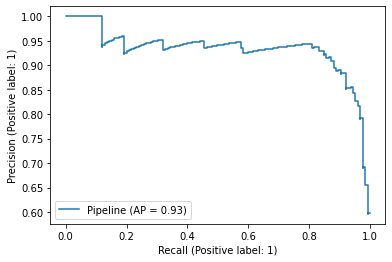

In [ ]:
PrecisionRecallDisplay.from_estimator(xgb_pipe, X_test, y_test);



AP = Average Precision: weighted average precision over all decision thresholds.  The increase in recall from previous threshold as the weight.

- The precision-recall curve shows the tradeoff between precision and recall for different threshold.
- A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.





### Which to use: ROC Curve or Precision-Recall Curve?


- Overall, the ROC Curve display is the better option to use in most situations.
- However, when we have extremely imbalanced data, the Precision-Recall curve is better.


For more information, see:

  - [Towards Data Science: How to Use ROC Curves and Preicsion-Recall Curves](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
